In [1]:
from torchvision import datasets,transforms,models
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import sys
import json
import copy
import random
import imageio

d:\Anaconda1\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_dir='./flower_data'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/valid'
valid_dir

'./flower_data/valid'

In [3]:
data_transforms={
    'train':
    transforms.Compose(
        [
            transforms.Resize([96,96]),
            # 数据增强  
            transforms.RandomRotation(45), # 随机旋转，-45·45度之间
            transforms.CenterCrop(64), #从中心开始裁剪
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2,contrast=0.1,saturation=0.1,hue=0.1), # 亮度、对比度、饱和度、色相
            transforms.RandomGrayscale(p=0.025),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值，标准化（三通道）
        ]
    ),
    'valid':
    transforms.Compose([
        transforms.Resize([96,96]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
batch_size=128

image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','valid']}
# shuffle变量在Python中用于表示是否对数据进行随机排序
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid']}
dataset_sizes={x:len(image_datasets[x]) for x in ['train','valid']}
class_names=image_datasets['train'].classes

In [5]:
with open('cat_to_name.json','r') as f:
    cat_to_name=json.load(f)

In [6]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [7]:
model_name='resnet'
feature_extract=True # 都用人家的特征，先不更新

In [8]:
train_on_gpu=torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available. Training on CPU ...


In [9]:
def set_paramters_required_grad(model,feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # 反向传播要不要计算梯度
            param.requires_grad=False

In [10]:
model_ft=models.resnet18() # 18层的能快点，条件好点的也可以轩152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 把模型输出层改成自己的

In [20]:
def initialize_model(num_classes,feature_extract,use_pretrained=True):
    # 18，50，101，152
    model_ft=models.resnet18(pretrained=use_pretrained)
    set_paramters_required_grad(model_ft,feature_extract)

    # 新加的层默认需要反向传播
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Linear(num_ftrs,num_classes)

    input_size=64
    return model_ft,input_size

In [12]:
model_ft,input_size=initialize_model(102,feature_extract)

model_ft=model_ft.to(device)

filename='checkpoint.pth'

# 是否训练所有层
params_to_update=model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update=[]
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


#### 优化器设置

In [13]:
# 优化器设置
optimizer_ft=optim.Adam(params_to_update,lr=1e-2) # 要更新的参数
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=10,gamma=0.1) #调用十次衰减一次
criterion=nn.CrossEntropyLoss()

#### 训练模块

In [14]:
def train_model(model,dataloaders,criterion,optimizer,num_epochs,filename='best.pt'):
    # 初始时间
    since=time.time()
    # 也要记录最好的那一次
    best_acc=0
    # 模型也得放到你的CPU或者GPU
    model.to(device)
    # 训练过程中打印一堆损失和指标
    val_acc_history=[]
    train_acc_history=[]
    train_losses=[]
    valid_losses=[]
    # 学习率
    LRs=[optimizer.param_groups[0]['lr']]
    best_model_wts=copy.deepcopy(model.state_dict())
    # 一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        # 训练和验证
        for phase in ['train','valid']:
            if phase=='train':
                model.train()
            else:
                model.eval()

            running_loss=0.0
            running_correct=0

            # 一次传进128个
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs=model(inputs)
                loss=criterion(outputs,labels)
                _,pred = torch.max(outputs,1)
                # 训练阶段更新权重
                if phase=='train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss+=loss.item()*inputs.size(0)
                running_correct+=torch.sum(pred==labels.data)

            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_correct.double()/len(dataloaders[phase].dataset)

            time_elapsed=time.time()-since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            if phase=='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                state={
                    'state_dict':model.state_dict(),
                    'best_acc':best_acc,
                    'optimizer':optimizer.state_dict(),
                }
                torch.save(state,filename)

            if phase=='valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)

            if phase=='train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
            
        print("Optimizer learning rate : {:.7f}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()

    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs

In [15]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs= train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
Time elapsed 1m 55s
train Loss: 3.9773 Acc: 0.2431
Time elapsed 2m 9s
valid Loss: 3.2479 Acc: 0.2714
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 3m 36s
train Loss: 2.7948 Acc: 0.4040
Time elapsed 3m 47s
valid Loss: 3.3346 Acc: 0.3081
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 5m 13s
train Loss: 2.7570 Acc: 0.4139
Time elapsed 5m 24s
valid Loss: 3.3987 Acc: 0.2848
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 6m 49s
train Loss: 2.7929 Acc: 0.4249
Time elapsed 7m 1s
valid Loss: 3.4588 Acc: 0.3032
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 8m 16s
train Loss: 2.7441 Acc: 0.4447
Time elapsed 8m 27s
valid Loss: 3.6937 Acc: 0.2922
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 9m 53s
train Loss: 2.7611 Acc: 0.4591
Time elapsed 10m 4s
valid Loss: 3.3661 Acc: 0.3276
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time elapsed 1

#### 再训练所有层

In [16]:
for param in model_ft.parameters():
    param.requires_grad=True

optimizer=optim.Adam(model_ft.parameters(),lr=1e-3)
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

criterion=nn.CrossEntropyLoss()

In [17]:
checkpoint=torch.load(filename)
best_acc=checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict']) 

<All keys matched successfully>

In [18]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs= train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
Time elapsed 2m 30s
train Loss: 0.5021 Acc: 0.8509
Time elapsed 2m 42s
valid Loss: 0.9311 Acc: 0.7616
Optimizer learning rate : 0.0001000

Epoch 1/9
----------
Time elapsed 5m 12s
train Loss: 0.4843 Acc: 0.8587
Time elapsed 5m 23s
valid Loss: 0.9663 Acc: 0.7579
Optimizer learning rate : 0.0001000

Epoch 2/9
----------
Time elapsed 7m 52s
train Loss: 0.4774 Acc: 0.8636
Time elapsed 8m 4s
valid Loss: 0.9395 Acc: 0.7506
Optimizer learning rate : 0.0001000

Epoch 3/9
----------
Time elapsed 10m 35s
train Loss: 0.4459 Acc: 0.8689
Time elapsed 10m 47s
valid Loss: 0.9911 Acc: 0.7641
Optimizer learning rate : 0.0001000

Epoch 4/9
----------
Time elapsed 13m 16s
train Loss: 0.4637 Acc: 0.8605
Time elapsed 13m 28s
valid Loss: 0.9536 Acc: 0.7543
Optimizer learning rate : 0.0001000

Epoch 5/9
----------
Time elapsed 16m 1s
train Loss: 0.4603 Acc: 0.8654
Time elapsed 16m 12s
valid Loss: 0.9764 Acc: 0.7604
Optimizer learning rate : 0.0001000

Epoch 6/9
----------
Time elapsed 18

#### 加载训练好的模型

In [26]:
model_ft=initialize_model(102,feature_extract,use_pretrained=True)
# model_ft[0]
model_ft=model_ft[0].to(device)

filename='best.pt'
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
# 加载模型                       
checkpoint=torch.load(filename)                                                                                          
best_acc=checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [28]:
# 得到一个batch的测试数据集
dataiter=iter(dataloaders['valid'])
images, labels = next(dataiter)
model_ft.eval()

if train_on_gpu:
    output=model_ft(images.cuda())
else:
    output=model_ft(images)

In [29]:
output.shape

torch.Size([128, 102])

In [30]:
_,preds_tensor=torch.max(output,1)

preds=np.squeeze(preds_tensor.numpy() if not train_on_gpu else np.squeez(preds_tensor.cpu().numpy()))
preds

array([ 74,  77,  82,  53,  78,  75,  59,  89,  76, 100,  47, 101,  96,
        15,  37,  73,  53,  10,  96,  37,  86, 100,  11,  17,  76,  53,
        83,  43,  78,  82,  89,  28,  51,  48,  80,  81,  89,  25,  64,
        40,  78,  18,  65,  74,  75,  96,  56,  15,   6,  76,  64,  33,
        56,  53,  23,  56,  64,  30,  79,   6,  82,  90,  12,  73,  79,
        18,  89,  13,  97,   5, 100,  35,  30,  55,  21,  85,  62,  88,
        89,  65,  81,  77,  53,  83,  99,  48,  18,  66,  80,  82,  96,
        55,  59,  85,  15,  45,  29,  49,  71,  70,  54,  27,  81,  49,
        76,  31,  49,  35,  53,  74,  32,  73,  96,  54,  49,  56,  77,
        20,  75,  48,  28,  99,  83,  77,  98,  12,  73,  72], dtype=int64)

In [31]:
def im_convert(tensor):

    image=tensor.to('cpu').clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    image=image.clip(0,1)
    return image

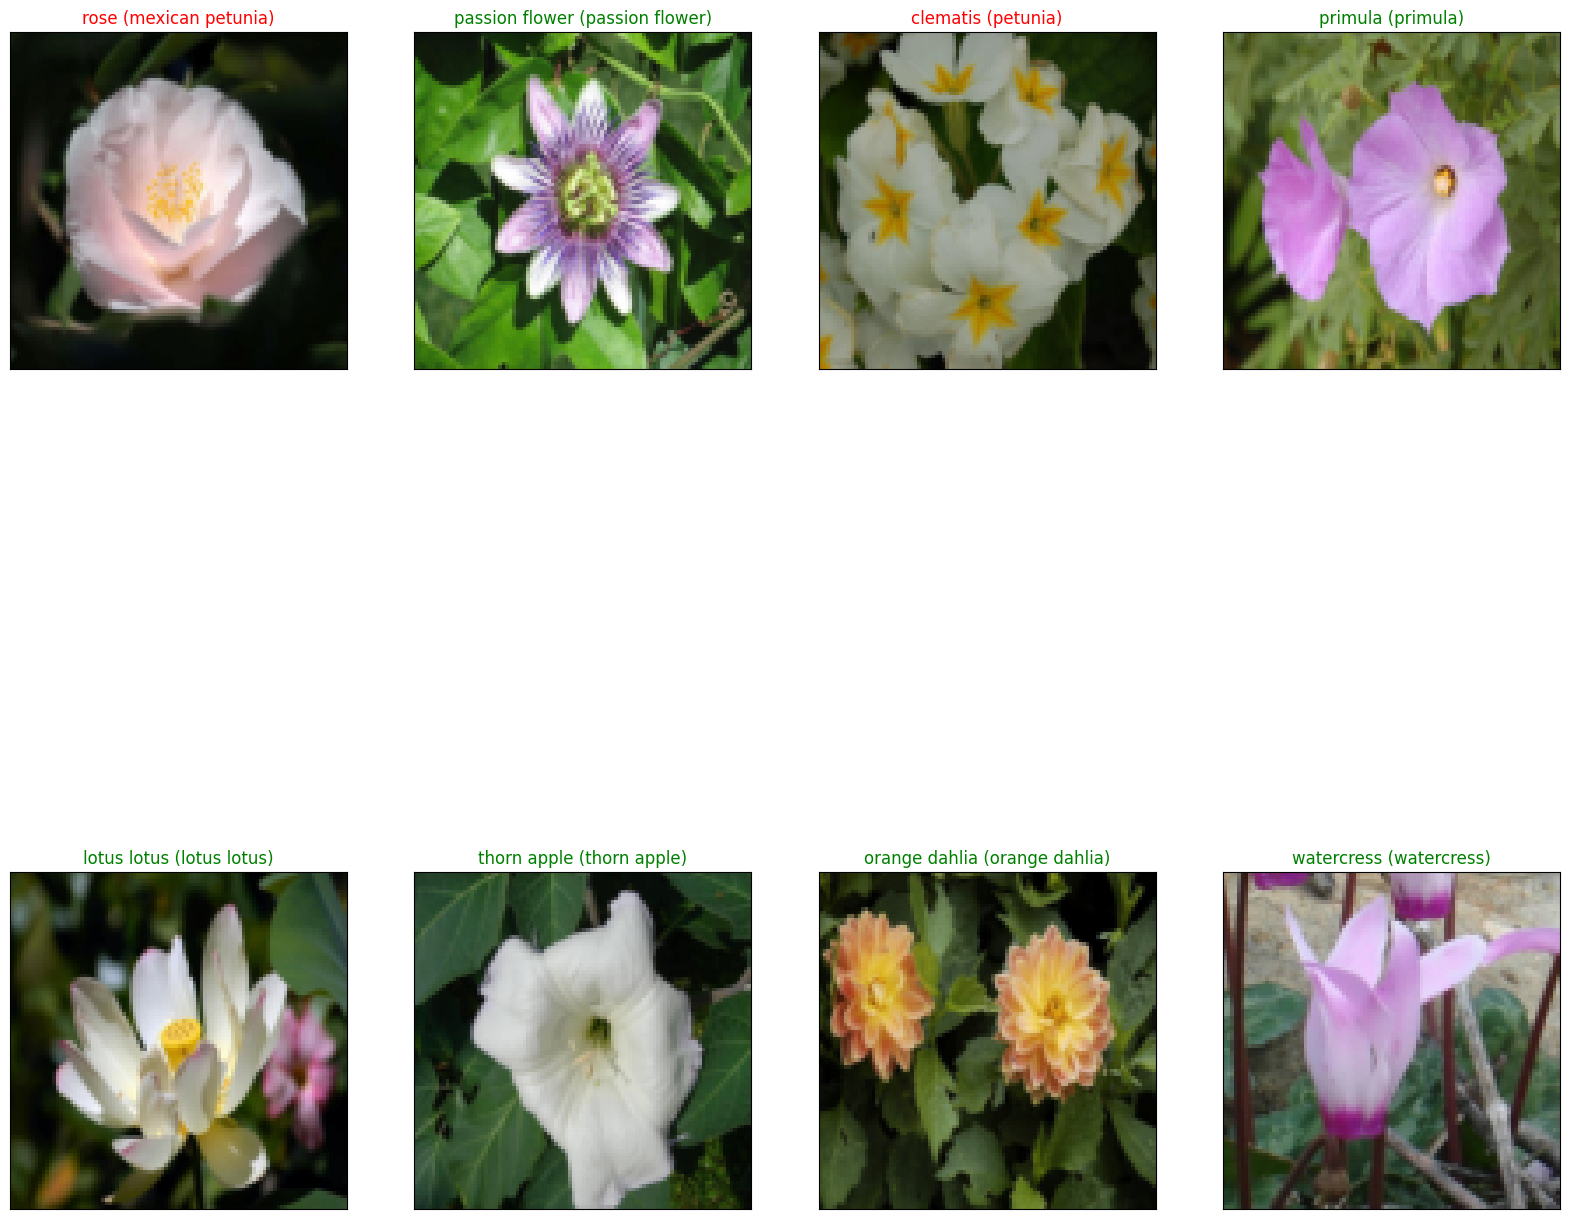

In [32]:
fig=plt.figure(figsize=(20,20))
columns=4
rows=2

for idx in range(columns*rows):
    ax=fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])],cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
    
plt.show()